In [65]:
import numpy as np
import pandas as pd

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.lut import make_lut_node
from architecture.nodes.ripper import make_ripper_node

In [66]:
train_df = pd.read_csv("./data/mnist/mnist_train.csv")
test_df = pd.read_csv("./data/mnist/mnist_test.csv")

input_values_train = train_df.drop(columns="label").to_numpy(bool)
target_values_train = train_df["label"].to_numpy(bool)

input_values_test = test_df.drop(columns="label").to_numpy(bool)
target_values_test = test_df["label"].to_numpy(bool)

print("Dataset shapes:")
print(f"TRAIN | input: {input_values_train.shape}, target: {target_values_train.shape}, pos. frac.: {target_values_train.mean():.3f}")
print(f"TEST  | input: {input_values_test.shape}, target: {target_values_test.shape}, pos. frac.: {target_values_test.mean():.3f}")

Dataset shapes:
TRAIN | input: (10000, 196), target: (10000,), pos. frac.: 0.486
TEST  | input: (1500, 196), target: (1500,), pos. frac.: 0.497


In [67]:
def get_node_accuracies_per_layer(model, input_values: np.ndarray, target_values: np.ndarray):
    if not model.layers:
        raise RuntimeError("Model not fitted")

    input_values = input_values.astype(bool, copy=False)
    if input_values.shape[1] != len(model.node_names[0]):
        raise ValueError(f"X must have shape (N, {len(model.node_names[0])})")

    accuracies_per_layer = []
    layer_input = input_values

    for layer_nodes, layer_backlinks in zip(model.layers, model.backlinks[1:]):
        node_outputs = [node(layer_input[:, bl]) for node, bl in zip(layer_nodes, layer_backlinks)]
        layer_output = np.column_stack(node_outputs)

        node_accuracies = []
        for j in range(layer_output.shape[1]):
            node_accuracy = (layer_output[:, j] == target_values).mean()
            node_accuracies.append(node_accuracy)

        accuracies_per_layer.append(node_accuracies)
        layer_input = layer_output

    return accuracies_per_layer

In [68]:
# setup architecture
hidden_layer_count  = 7
layer_node_count    = 32
layer_bit_count     = 4

In [69]:
# train lut network
lut_net = DeepBinaryClassifier(
    layer_node_counts = [layer_node_count]*hidden_layer_count + [1],
    layer_bit_counts  = [layer_bit_count]*(hidden_layer_count + 1),
    node_factory      = make_lut_node,
    seed              = 42
)
%time lut_net.fit(input_values_train, target_values_train)

lut_node_accs = get_node_accuracies_per_layer(lut_net, input_values_train, target_values_train)
lut_layer_acc_means = [np.mean(accs) for accs in lut_node_accs]
lut_layer_acc_stds  = [np.std(accs)  for accs in lut_node_accs]

CPU times: user 51.3 ms, sys: 35.8 ms, total: 87.2 ms
Wall time: 85.6 ms


In [70]:
# train ripper network
ripper_net = DeepBinaryClassifier(
    layer_node_counts = [layer_node_count]*hidden_layer_count + [1],
    layer_bit_counts  = [layer_bit_count]*(hidden_layer_count + 1),
    node_factory      = make_ripper_node,
    seed              = 42,
    jobs              = 8
)
%time ripper_net.fit(input_values_train, target_values_train)

ripper_node_accs = get_node_accuracies_per_layer(ripper_net, input_values_train, target_values_train)
ripper_layer_acc_means = [np.mean(accs) for accs in ripper_node_accs]
ripper_layer_acc_stds  = [np.std(accs)  for accs in ripper_node_accs]

CPU times: user 415 ms, sys: 373 ms, total: 788 ms
Wall time: 36.1 s


In [74]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif"})

def plot_layer_accuracy(
        lut_means,
        lut_stds,
        ripper_means,
        ripper_stds,
        hidden_layer_count,
        dpi: int = 120
):
    lut_color = "#a24a55"
    ripper_color = "#2e5f7f"
    face_color = "white"

    L = hidden_layer_count + 1
    layer_idx = np.arange(1, L + 1)

    fig, ax = plt.subplots(figsize=(10, 5), dpi=dpi, facecolor=face_color)
    ax.set_facecolor(face_color)

    ax.errorbar(layer_idx, lut_means, yerr=lut_stds, fmt="s--",
                capsize=4, color=lut_color, markersize=6, label=r"$\text{LUT}$", zorder=2)

    ax.errorbar(layer_idx, ripper_means, yerr=ripper_stds, fmt="s--",
                capsize=4, color=ripper_color, markersize=6, label=r"$\text{RIPPER}$", zorder=2)

    ax.set_xticks(layer_idx)
    ax.set_xticklabels([f"$L_{{{i}}}$" for i in layer_idx])

    y_ticks = np.linspace(0.5, 0.8, 7)   # nice clean steps
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"${t:.2f}$" for t in y_ticks])

    ax.set_xlabel(r"$\text{layer}$", fontsize=16)
    ax.set_ylabel(r"$\text{accuracy}$", fontsize=16)
    ax.set_title(rf"$\text{{Test Accuracy per Layer}}$", fontsize=16)

    ax.legend(frameon=True, framealpha=1, fontsize=14, loc="lower right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.3, linewidth=0.8)

    plt.tight_layout()
    return fig, ax

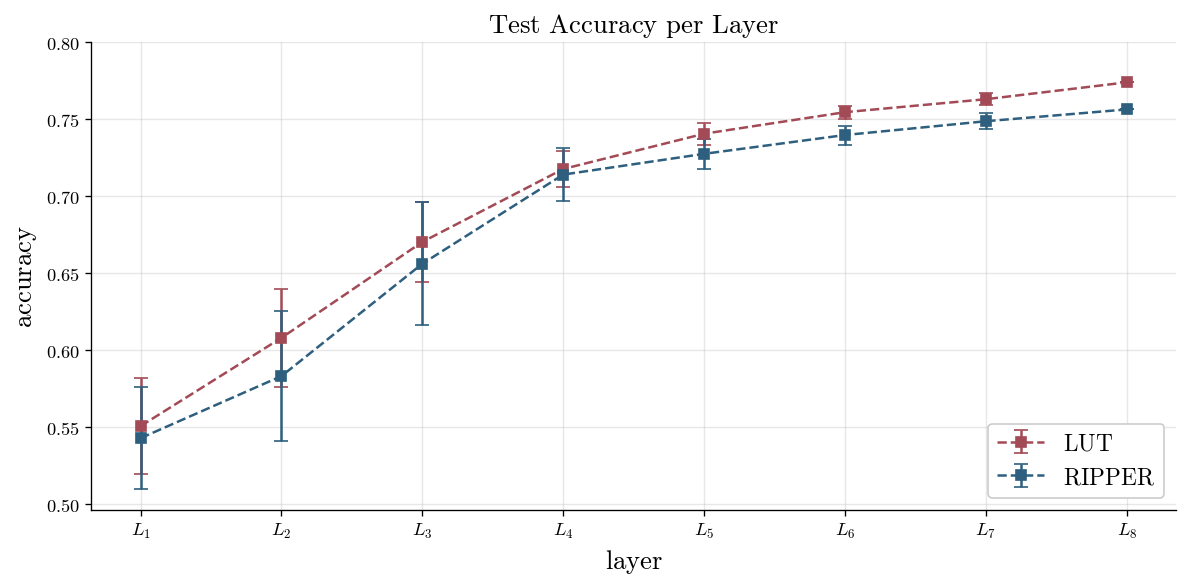

In [75]:
fig, ax = plot_layer_accuracy(lut_layer_acc_means, lut_layer_acc_stds,
                              ripper_layer_acc_means, ripper_layer_acc_stds, hidden_layer_count)
plt.show()

In [76]:
fig.savefig("./figures/mnist_deep_depth_comparison.png", dpi=300)